In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso, lasso_path


warnings.filterwarnings("ignore")

## Selection LASSO 

Dans cette analyse, nous nous plaçons en **janvier 2009** afin de réaliser une régression LASSO sur une base de 20 titres. L'idée est que l'on souhaite construire un portefeuille en janvier 2010 (avec les pondérations/titres obtenus via la méthode LASSO établis sur la période précédente).  



Dans notre projet, la régression LASSO (Least Absolute Shrinkage and Selection Operator) sert à sélectionner les titres les plus pertinents parmi un ensemble de titres en fonction de leur capacité à expliquer la performance du benchmark (le CAC40).

* Le LASSO aide à identifier quels titres parmi tous les disponibles ont le plus d'influence sur les rendements du benchmark.
* Cela permet d'éliminer les titres peu pertinents et de ne garder que ceux qui sont significatifs pour expliquer les variations du benchmark.
* On retiendra les 10 titres ayant le plus gros coefficients suite à la régression LASSO

In [4]:
tickers = [
    "TTE.PA",      # TotalEnergies
    "BN.PA",       # Danone
    "SAN.PA",      # Sanofi
    "BNP.PA",      # BNP Paribas
    "ENGI.PA",     # Engie
    "ORA.PA",      # Orange
    "MC.PA",       # LVMH Moet Hennessy
    "CS.PA",       # AXA
    "OR.PA",       # L'Oréal
    "GLE.PA",      # Société Générale
    "AI.PA",       # Air Liquide
    "VIV.PA",      # Vivendi
    "DG.PA",       # Vinci
    "MT.AS",       # ArcelorMittal
    "RI.PA",       # Pernod Ricard
    "SGO.PA",      # Saint-Gobain
    "SU.PA",       # Schneider Electric
    "CA.PA",       # Carrefour SA
    "VIE.PA",      # Veolia Environnement
    "ALO.PA"       # Alstom
]

data = yf.download(tickers, start="2009-01-01", end="2024-01-01")['Adj Close']
benchmark = yf.download("^FCHI", start="2009-01-01", end="2024-01-01")['Adj Close']

# Séparer les données pour la période de sélection (2009-2010) et évaluation (2010-2024)
data_train = data['2009':'2010']
data_test = data['2010':'2024']
benchmark_train = benchmark['2009':'2010']
benchmark_test = benchmark['2010':'2024']

# Calculer les rendements quotidiens
daily_returns_train = data_train.pct_change().dropna()
daily_returns_test = data_test.pct_change().dropna()
benchmark_returns_train = benchmark_train.pct_change().dropna()
benchmark_returns_test = benchmark_test.pct_change().dropna()

[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


In [10]:
aligned_returns_train, aligned_benchmark_train = daily_returns_train.align(benchmark_returns_train, join='inner', axis=0)

# Vérifier que l'alignement s'est bien effectué
print(aligned_returns_train.head())
print(aligned_benchmark_train.head())

# Standardisation des données pour LASSO
scaler = StandardScaler()
X_train = scaler.fit_transform(aligned_returns_train)  # Rendements des titres après alignement
y_train = scaler.fit_transform(aligned_benchmark_train.values.reshape(-1, 1)).ravel()  # Rendement du CAC40 aligné

# Utiliser LassoCV pour déterminer l'alpha optimal avec validation croisée
lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# Alpha optimal
optimal_alpha = lasso_cv.alpha_
print(f"L'alpha optimal est : {optimal_alpha}")

# Extraction des titres sélectionnés avec l'alpha optimal
selected_tickers = aligned_returns_train.columns[lasso_cv.coef_ != 0]
selected_weights = lasso_cv.coef_[lasso_cv.coef_ != 0]

# Normalisation des poids pour que la somme soit égale à 1
normalized_weights = selected_weights / np.sum(np.abs(selected_weights))

# Sauvegarder les tickers sélectionnés
portfolio_composition = pd.DataFrame({
    'Ticker': selected_tickers,
    'Weight': normalized_weights
})
print("Composition du portefeuille après sélection LASSO avec l'alpha optimal :")
print(portfolio_composition)

# Sauvegarder les tickers sélectionnés
selected_tickers_df = pd.DataFrame({
    'Ticker': selected_tickers,
    'Coefficient': normalized_weights
})
selected_tickers_df.to_csv("selected_tickers_lasso_D.csv", index=False)

Ticker         AI.PA    ALO.PA     BN.PA    BNP.PA     CA.PA     CS.PA  \
Date                                                                     
2009-01-05  0.003630  0.008144  0.009868 -0.025841 -0.019841 -0.002055   
2009-01-06  0.006642  0.017888  0.004885  0.070476  0.000346  0.008824   
2009-01-07 -0.014223 -0.002381 -0.015138  0.026393  0.001556 -0.039650   
2009-01-08  0.007735 -0.043528  0.004039 -0.004571 -0.037126 -0.039162   
2009-01-09 -0.011734 -0.036003 -0.006928 -0.022245 -0.004663 -0.024644   

Ticker         DG.PA   ENGI.PA    GLE.PA     MC.PA     MT.AS     OR.PA  \
Date                                                                     
2009-01-05  0.005984  0.017554 -0.014290  0.009505  0.002396 -0.017528   
2009-01-06  0.018007 -0.049805  0.020788  0.012075  0.135192  0.006729   
2009-01-07 -0.009160 -0.010981 -0.008842 -0.012437 -0.030416 -0.030001   
2009-01-08 -0.009723  0.006514 -0.005137 -0.035118 -0.015203 -0.001843   
2009-01-09 -0.006438 -0.023239 -0.021

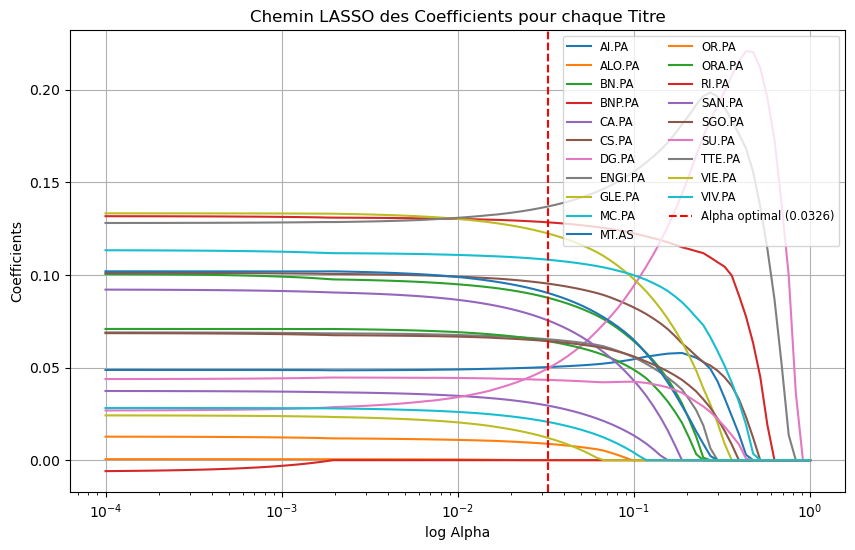

In [12]:
# Calcul des chemins LASSO pour une série d'alphas
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=np.logspace(-4, 0, 100))

# Visualisation des chemins LASSO avec l'alpha optimal
plt.figure(figsize=(10, 6))
for i, ticker in enumerate(aligned_returns_train.columns):
    plt.plot(alphas_lasso, coefs_lasso[i], label=ticker)

# Marquer l'alpha optimal
plt.axvline(x=optimal_alpha, color='red', linestyle='--', label=f'Alpha optimal ({optimal_alpha:.4f})')
plt.xscale('log')  # Échelle logarithmique pour alpha
plt.xlabel('log Alpha')
plt.ylabel('Coefficients')
plt.title('Chemin LASSO des Coefficients pour chaque Titre')
plt.legend(loc='best', fontsize='small', ncol=2)
plt.grid(True)
plt.show()

In [14]:
# Export to Excel

coefficients_df = pd.DataFrame(coefs_lasso.T, index=alphas_lasso, columns=aligned_returns_train.columns)
lasso_path_csv_path = 'lasso_path_coefficients_D.csv'
coefficients_df.to_csv(lasso_path_csv_path)
lasso_path_csv_path

'lasso_path_coefficients_D.csv'

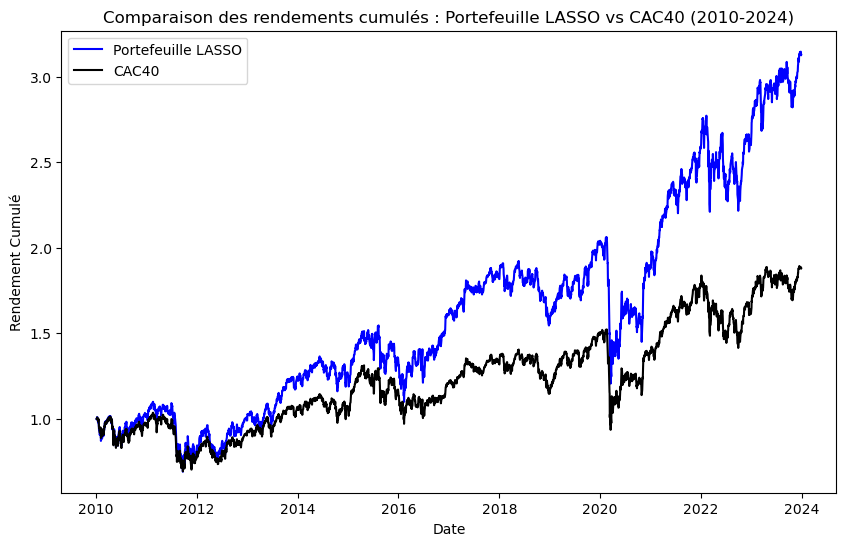

Performance du Portefeuille LASSO :
  - Rendement Total: 212.84%
  - Rendement Annualisé: 10.61%
  - Volatilité Annualisée: 22.73%
  - Ratio de Sharpe: 0.47

Performance du CAC40 :
  - Rendement Total: 87.92%
  - Rendement Annualisé: 6.47%
  - Volatilité Annualisée: 20.10%
  - Ratio de Sharpe: 0.32


In [18]:
# Calculer les rendements du portefeuille basé sur la sélection LASSO pour la période de test (2010-2024)
portfolio_returns_test = daily_returns_test[selected_tickers].dot(normalized_weights)

# Calcul des rendements cumulés du portefeuille
portfolio_cumulative_returns_test = (1 + portfolio_returns_test).cumprod()

# Calcul des rendements cumulés du benchmark (CAC40)
benchmark_cumulative_returns_test = (1 + benchmark_returns_test).cumprod()

# Visualisation des rendements cumulés
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cumulative_returns_test, label='Portefeuille LASSO', color='blue')
plt.plot(benchmark_cumulative_returns_test, label='CAC40', color='black')
plt.title('Comparaison des rendements cumulés : Portefeuille LASSO vs CAC40 (2010-2024)')
plt.xlabel('Date')
plt.ylabel('Rendement Cumulé')
plt.legend()
plt.grid(False)
plt.show()

# Calcul des statistiques de performance du portefeuille LASSO
total_return_portfolio = portfolio_cumulative_returns_test[-1] - 1
annualized_return_portfolio = portfolio_returns_test.mean() * 252  # Moyenne quotidienne annualisée
annualized_volatility_portfolio = portfolio_returns_test.std() * np.sqrt(252)  # Volatilité annualisée
sharpe_ratio_portfolio = annualized_return_portfolio / annualized_volatility_portfolio  # Ratio de Sharpe

# Calcul des statistiques de performance du benchmark CAC40
total_return_benchmark = benchmark_cumulative_returns_test[-1] - 1
annualized_return_benchmark = benchmark_returns_test.mean() * 252  # Moyenne quotidienne annualisée
annualized_volatility_benchmark = benchmark_returns_test.std() * np.sqrt(252)  # Volatilité annualisée
sharpe_ratio_benchmark = annualized_return_benchmark / annualized_volatility_benchmark  # Ratio de Sharpe

# Afficher les résultats
print(f"Performance du Portefeuille LASSO :")
print(f"  - Rendement Total: {total_return_portfolio:.2%}")
print(f"  - Rendement Annualisé: {annualized_return_portfolio:.2%}")
print(f"  - Volatilité Annualisée: {annualized_volatility_portfolio:.2%}")
print(f"  - Ratio de Sharpe: {sharpe_ratio_portfolio:.2f}")

print(f"\nPerformance du CAC40 :")
print(f"  - Rendement Total: {total_return_benchmark:.2%}")
print(f"  - Rendement Annualisé: {annualized_return_benchmark:.2%}")
print(f"  - Volatilité Annualisée: {annualized_volatility_benchmark:.2%}")
print(f"  - Ratio de Sharpe: {sharpe_ratio_benchmark:.2f}")

In [27]:
# Export sous Excel
performance_stats = pd.DataFrame({
    'Statistique': ['Rendement Total', 'Rendement Annualisé', 'Volatilité Annualisée', 'Ratio de Sharpe'],
    'Portefeuille LASSO': [
        total_return_portfolio,
        annualized_return_portfolio,
        annualized_volatility_portfolio,
        sharpe_ratio_portfolio
    ],
    'CAC 40': [
        total_return_benchmark,
        annualized_return_benchmark,
        annualized_volatility_benchmark,
        sharpe_ratio_benchmark
    ]
})

# Exportation des données vers un fichier Excel
excel_file_path = 'portfolio_performance_data_D.xlsx'
with pd.ExcelWriter(excel_file_path) as writer:
    # Exporter les rendements cumulés du portefeuille
    portfolio_cumulative_returns_test.to_frame(name='Portfolio Cumulative Returns').to_excel(writer, sheet_name='Portfolio Returns')
    
    # Exporter les rendements cumulés du benchmark CAC40
    benchmark_cumulative_returns_test.to_frame(name='CAC40 Cumulative Returns').to_excel(writer, sheet_name='CAC40 Returns')
    
    # Exporter les statistiques de performance
    performance_stats.to_excel(writer, sheet_name='Performance Stats')

print(f'Données exportées avec succès vers {excel_file_path}')

Données exportées avec succès vers portfolio_performance_data_D.xlsx


In [37]:
tickers = [
    "AI.PA", "ALO.PA", "BN.PA", "BNP.PA", "CA.PA", "CS.PA", "DG.PA", "ENGI.PA",
    "GLE.PA", "MC.PA", "MT.AS", "ORA.PA", "SAN.PA", "SGO.PA", "SU.PA", "TTE.PA", 
    "VIE.PA", "VIV.PA"
]

weights = np.array([
    0.040144,  # AI.PA
    0.007026,  # ALO.PA
    0.069973,  # BN.PA
    0.102520,  # BNP.PA
    0.023498,  # CA.PA
    0.076092,  # CS.PA
    0.039660,  # DG.PA
    0.052117,  # ENGI.PA
    0.097701,  # GLE.PA
    0.086400,  # MC.PA
    0.072037,  # MT.AS
    0.051298,  # ORA.PA
    0.060198,  # SAN.PA
    0.051311,  # SGO.PA
    0.034599,  # SU.PA
    0.109387,  # TTE.PA
    0.009569,  # VIE.PA
    0.016470   # VIV.PA
])

# Taux sans risque (par exemple, à 0.5%)
risk_free_rate = 0.005 / 252

# Initialize lists to store results for export to Excel
results_for_export = {
    'Year': [],
    'Portfolio Cumulative Return (%)': [],
    'Benchmark Cumulative Return (%)': [],
    'Portfolio Annual Return (%)': [],
    'Benchmark Annual Return (%)': [],
    'Portfolio Volatility (%)': [],
    'Benchmark Volatility (%)': [],
    'Sharpe Ratio Portfolio': [],
    'Sharpe Ratio Benchmark': []
}

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


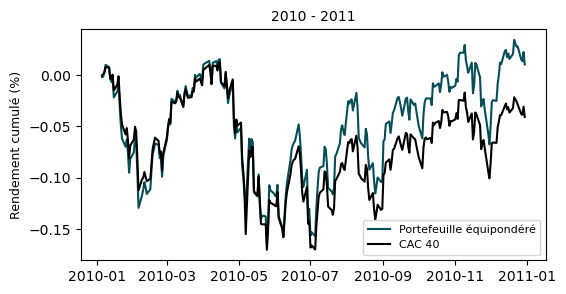

[*****                 11%%                      ]  2 of 18 completed

Performance du Portefeuille de 2010 à 2011 : 1.04%
Performance du Benchmark (CAC 40) de 2010 à 2011 : -4.07%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2010 à 2011 : 0.14
Sharpe Ratio du Benchmark (CAC 40) de 2010 à 2011 : -0.08



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


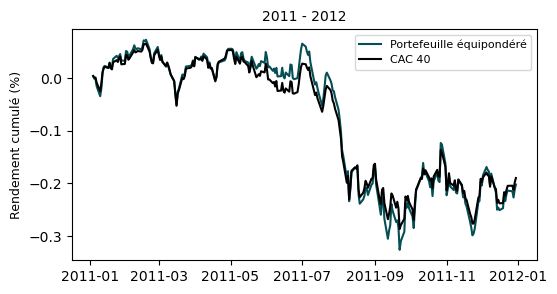

[********              17%%                      ]  3 of 18 completed

Performance du Portefeuille de 2011 à 2012 : -20.23%
Performance du Benchmark (CAC 40) de 2011 à 2012 : -19.00%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2011 à 2012 : -0.49
Sharpe Ratio du Benchmark (CAC 40) de 2011 à 2012 : -0.60



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


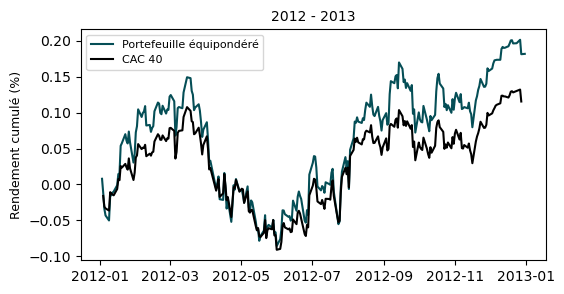

[*****                 11%%                      ]  2 of 18 completed

Performance du Portefeuille de 2012 à 2013 : 18.18%
Performance du Benchmark (CAC 40) de 2012 à 2013 : 11.55%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2012 à 2013 : 0.76
Sharpe Ratio du Benchmark (CAC 40) de 2012 à 2013 : 0.61



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


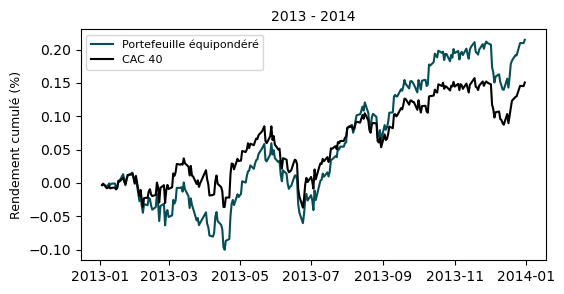

Performance du Portefeuille de 2013 à 2014 : 21.46%
Performance du Benchmark (CAC 40) de 2013 à 2014 : 15.05%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2013 à 2014 : 1.13
Sharpe Ratio du Benchmark (CAC 40) de 2013 à 2014 : 0.92



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


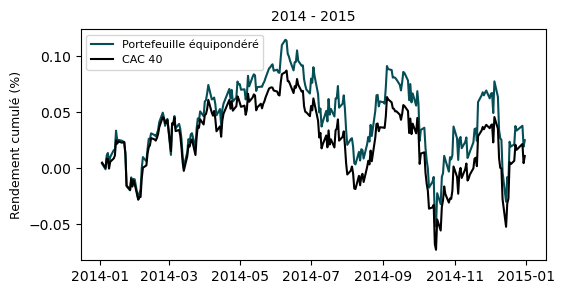

[                       0%%                      ]

Performance du Portefeuille de 2014 à 2015 : 2.48%
Performance du Benchmark (CAC 40) de 2014 à 2015 : 1.08%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2014 à 2015 : 0.20
Sharpe Ratio du Benchmark (CAC 40) de 2014 à 2015 : 0.12



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


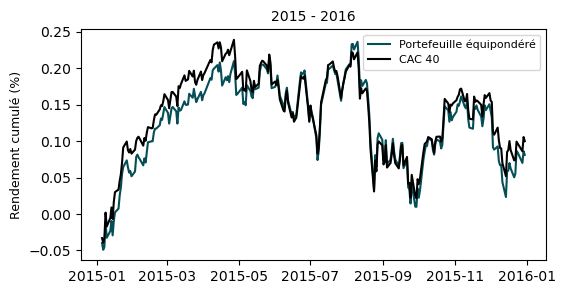

[                       0%%                      ]

Performance du Portefeuille de 2015 à 2016 : 8.11%
Performance du Benchmark (CAC 40) de 2015 à 2016 : 9.99%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2015 à 2016 : 0.42
Sharpe Ratio du Benchmark (CAC 40) de 2015 à 2016 : 0.51



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


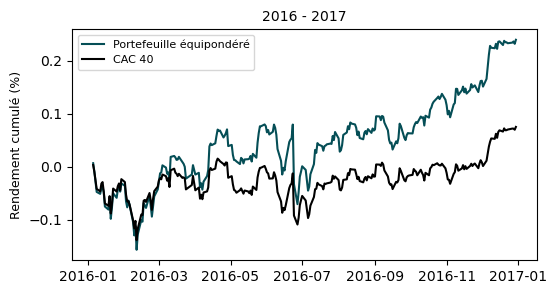

Performance du Portefeuille de 2016 à 2017 : 23.94%
Performance du Benchmark (CAC 40) de 2016 à 2017 : 7.51%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2016 à 2017 : 0.95
Sharpe Ratio du Benchmark (CAC 40) de 2016 à 2017 : 0.43



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


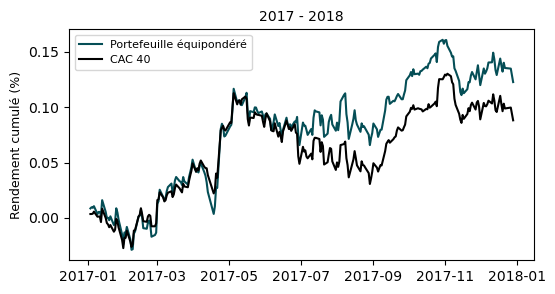

Performance du Portefeuille de 2017 à 2018 : 12.26%
Performance du Benchmark (CAC 40) de 2017 à 2018 : 8.81%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2017 à 2018 : 0.97
Sharpe Ratio du Benchmark (CAC 40) de 2017 à 2018 : 0.80



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


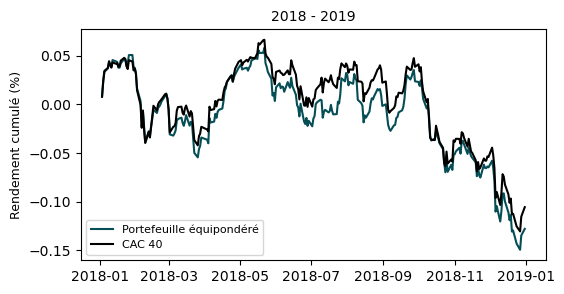

Performance du Portefeuille de 2018 à 2019 : -12.78%
Performance du Benchmark (CAC 40) de 2018 à 2019 : -10.55%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2018 à 2019 : -0.94
Sharpe Ratio du Benchmark (CAC 40) de 2018 à 2019 : -0.77



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


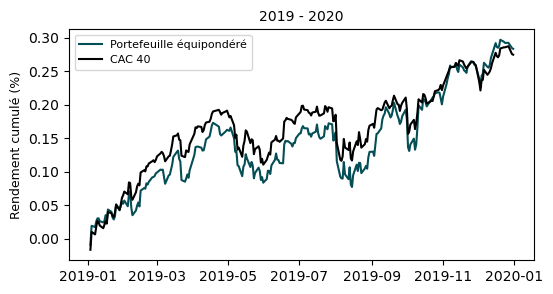

Performance du Portefeuille de 2019 à 2020 : 28.36%
Performance du Benchmark (CAC 40) de 2019 à 2020 : 27.48%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2019 à 2020 : 1.70
Sharpe Ratio du Benchmark (CAC 40) de 2019 à 2020 : 1.85



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


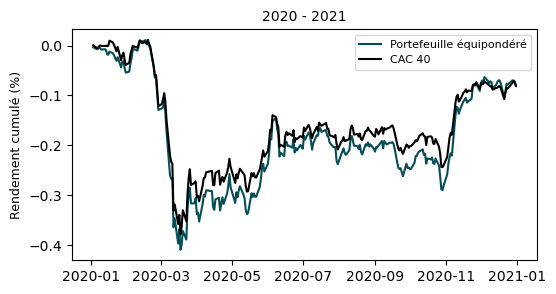

[                       0%%                      ]

Performance du Portefeuille de 2020 à 2021 : -8.00%
Performance du Benchmark (CAC 40) de 2020 à 2021 : -8.11%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2020 à 2021 : -0.04
Sharpe Ratio du Benchmark (CAC 40) de 2020 à 2021 : -0.11



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


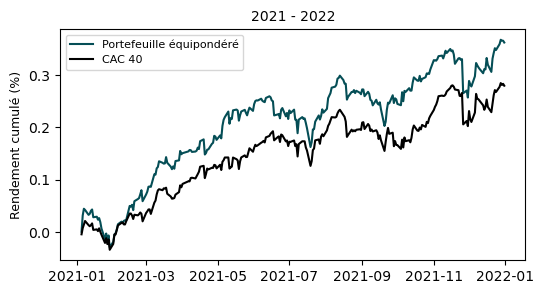

[                       0%%                      ]

Performance du Portefeuille de 2021 à 2022 : 36.25%
Performance du Benchmark (CAC 40) de 2021 à 2022 : 27.98%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2021 à 2022 : 2.00
Sharpe Ratio du Benchmark (CAC 40) de 2021 à 2022 : 1.77



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


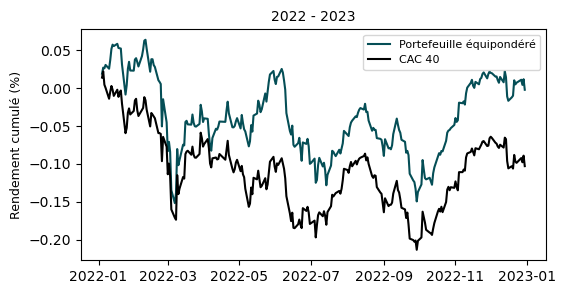

Performance du Portefeuille de 2022 à 2023 : -0.22%
Performance du Benchmark (CAC 40) de 2022 à 2023 : -10.30%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2022 à 2023 : 0.08
Sharpe Ratio du Benchmark (CAC 40) de 2022 à 2023 : -0.39



[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


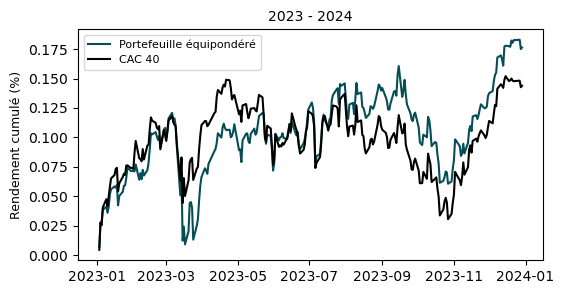

Performance du Portefeuille de 2023 à 2024 : 17.63%
Performance du Benchmark (CAC 40) de 2023 à 2024 : 14.38%

Results have been exported to portfolio_vs_benchmark_analysis_D.xlsx
Sharpe Ratio du Portefeuille de 2023 à 2024 : 1.17
Sharpe Ratio du Benchmark (CAC 40) de 2023 à 2024 : 1.00



In [41]:
# Boucle pour visualiser les performances du portefeuille vs benchmark (CAC 40) pour chaque année
for start_year in range(2010, 2024):
    end_year = start_year + 1
    
    # Étape 1: Télécharger les données historiques pour le portefeuille et le CAC 40 pour une période d'un an
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-01-01"
    
    portfolio_data = yf.download(tickers, start=start_date, end=end_date, interval="1d")['Adj Close']
    benchmark_data = yf.download("^FCHI", start=start_date, end=end_date, interval="1d")['Adj Close']
    
    # Étape 2: Calculer les rendements journaliers pour chaque action du portefeuille
    portfolio_returns = portfolio_data.pct_change()
    
    # Étape 3: Calculer le rendement pondéré du portefeuille
    portfolio_weighted_return = portfolio_returns.dot(weights)
    
    # Étape 4: Calculer les rendements journaliers du benchmark (CAC 40)
    benchmark_returns = benchmark_data.pct_change()
    
    # Étape 5: Calculer les rendements cumulés pour le portefeuille et le benchmark
    portfolio_cumulative_return = (1 + portfolio_weighted_return).cumprod() - 1
    benchmark_cumulative_return = (1 + benchmark_returns).cumprod() - 1
    
    # Étape 6: Tracer les rendements cumulés pour comparaison
    plt.figure(figsize=(6, 3))
    plt.plot(portfolio_cumulative_return, label="Portefeuille équipondéré", color="#054E56")
    plt.plot(benchmark_cumulative_return, label="CAC 40", color="black")
    plt.title(f"{start_year} - {end_year}", fontsize=10)
    plt.xlabel("", fontsize=6)
    plt.ylabel("Rendement cumulé (%)", fontsize=9)
    plt.legend(fontsize=8)
    plt.grid(False)
    plt.show()
    
    # Étape 7: Calculer et afficher la performance finale en pourcentage pour le portefeuille et le benchmark
    portfolio_performance_percent = portfolio_cumulative_return.iloc[-1] * 100
    benchmark_performance_percent = benchmark_cumulative_return.iloc[-1] * 100
    print(f"Performance du Portefeuille de {start_year} à {end_year} : {portfolio_performance_percent:.2f}%")
    print(f"Performance du Benchmark (CAC 40) de {start_year} à {end_year} : {benchmark_performance_percent:.2f}%\n")

    # Étape 8: Calculer la volatilité annuelle du portefeuille
    portfolio_volatility = portfolio_weighted_return.std() * np.sqrt(252)
    
    # Étape 9: Calculer la volatilité annuelle du benchmark
    benchmark_volatility = benchmark_returns.std() * np.sqrt(252)

    # Étape 10: Calculer le rendement annuel moyen du portefeuille
    portfolio_annual_return = portfolio_weighted_return.mean() * 252

    # Étape 11: Calculer le rendement annuel moyen du benchmark
    benchmark_annual_return = benchmark_returns.mean() * 252

    # Étape 12: Calculer le Ratio de Sharpe pour le portefeuille
    excess_portfolio_returns = portfolio_weighted_return - risk_free_rate
    sharpe_ratio_portfolio = (excess_portfolio_returns.mean() * 252) / portfolio_volatility

    # Étape 13: Calculer le Ratio de Sharpe pour le Benchmark (CAC 40)
    excess_benchmark_returns = benchmark_returns - risk_free_rate
    sharpe_ratio_benchmark = (excess_benchmark_returns.mean() * 252) / benchmark_volatility

    # Store the results for export
    results_for_export['Year'].append(start_year)
    results_for_export['Portfolio Cumulative Return (%)'].append(portfolio_performance_percent)
    results_for_export['Benchmark Cumulative Return (%)'].append(benchmark_performance_percent)
    results_for_export['Portfolio Annual Return (%)'].append(portfolio_annual_return)
    results_for_export['Benchmark Annual Return (%)'].append(benchmark_annual_return)
    results_for_export['Portfolio Volatility (%)'].append(portfolio_volatility * 100)
    results_for_export['Benchmark Volatility (%)'].append(benchmark_volatility * 100)
    results_for_export['Sharpe Ratio Portfolio'].append(sharpe_ratio_portfolio)
    results_for_export['Sharpe Ratio Benchmark'].append(sharpe_ratio_benchmark)

    results_df = pd.DataFrame(results_for_export)
    file_path = 'portfolio_vs_benchmark_analysis_D.xlsx'
    results_df.to_excel(file_path, index=True)

    print(f"Results have been exported to {file_path}")
    # Affichage des résultats
    print(f"Sharpe Ratio du Portefeuille de {start_year} à {end_year} : {sharpe_ratio_portfolio:.2f}")
    print(f"Sharpe Ratio du Benchmark (CAC 40) de {start_year} à {end_year} : {sharpe_ratio_benchmark:.2f}\n")